In [1]:
import time
import copy
import random
import numpy as np
import distance
import math
import pandas as pd
from scipy.spatial import distance
from collections import Counter

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import optim

from IPython.display import Audio

random.seed(666)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Meow function to run after model is finished training.

In [2]:
def allDone():
    return Audio('meow.wav', autoplay=True)

### Training data.

In [9]:
train_motifs = np.genfromtxt('data/7472_motifs.csv',dtype='U')
train_motifxFamMatrix = np.genfromtxt('data/7472_motifxFamMatrix.csv',delimiter=',',dtype=int)
test_motifs = np.genfromtxt('data/1643_motifs.csv',dtype='U')
test_motifxFamMatrix = np.genfromtxt('data/1643_motifxFamMatrix.csv',delimiter=',',dtype=int)
fams = np.genfromtxt('data/large_fams.csv',dtype='U')

all_motifs = np.hstack([train_motifs,test_motifs])
all_motifxFamMatrix = np.vstack([train_motifxFamMatrix,test_motifxFamMatrix])#

X_train, X_val = train_test_split(range(len(train_motifs)), test_size=0.1, random_state=666)

print(len(X_train), len(X_val), len(test_motifs))

6724 748 1643


### Data pre-processing.

In [10]:
gram_length = 3

def get_gram_seq(motif,gram_length=1):
    gram_seq = []
    for i in range(len(motif)):
        gram = motif[i:i+gram_length]
        gram_seq.append(gram)
    return gram_seq

def get_encoded_motifs(grammed_motifs, all_grams):
    gram_counts = Counter(all_grams)
    gram_list = sorted(gram_counts, key=gram_counts.get, reverse=True)
    gram_to_int = {gram:idx+1 for idx, gram in enumerate(gram_list)}  
    encoded_motifs = [[gram_to_int[gram] for gram in motif] for motif in grammed_motifs]
    return encoded_motifs, gram_to_int, gram_list

AMINOS = 'XWGSAELQDMPFTRIHVNCY_K'

all_grams = []
train_grammed_motifs = []
for motif in train_motifs:
    grammed_motif = get_gram_seq(motif,gram_length)
    train_grammed_motifs.append(grammed_motif)
    all_grams.extend(grammed_motif)
    
test_grammed_motifs = []
for motif in test_motifs:
    grammed_motif = get_gram_seq(motif,gram_length)
    test_grammed_motifs.append(grammed_motif)
    all_grams.extend(grammed_motif)
    
vocab_size = len(set(all_grams))
print("vocab size:",vocab_size)

train_encoded_motifs, gram_to_int, gram_list = get_encoded_motifs(train_grammed_motifs, all_grams)
test_encoded_motifs, gram_to_int, gram_list = get_encoded_motifs(test_grammed_motifs, all_grams)
all_encoded_motifs = train_encoded_motifs + test_encoded_motifs

vocab size: 7927


### Functions relevant to model training.

In [11]:
def my_jaccard(set1, set2):
    assert isinstance(set1, set), "`set1` is not a set."
    assert isinstance(set2, set), "`set2` is not a set."
    return 1 - (len(set1.intersection(set2)) / len(set1.union(set2)))

In [12]:
def get_random_motif_and_fam(idc):
    mIdx = random.choice(idc)  
    motif = train_encoded_motifs[mIdx] 
    fIdx = np.where(train_motifxFamMatrix[mIdx]==1)
    theseFams = fams[fIdx]
    return (mIdx,motif,fIdx,theseFams)

def get_batch(idc,batch_size):
    batch = []
    switch = 0
    
    while switch < batch_size:
        mIdx_1, motif_1, fIdx_1, fams_1 = get_random_motif_and_fam(idc)
        mIdx_2, motif_2, fIdx_2, fams_2 = get_random_motif_and_fam(idc)
        
        if len(fams_1)==0 and len(fams_2)==0: 
            continue
        
        label = my_jaccard(set(fams_1), set(fams_2))
        if switch%2 != round(label):     # math.ceil(label):
            continue
        switch += 1
            
        triplet = [motif_1, motif_2, label]
        batch.append(triplet)

    return batch


def evaluate(model, idc, criterion, iters, batch_size, margin, dist_type):
    model.eval()
    loss_history = 0

    with torch.no_grad():
        
        for i in range(iters):
            batch = get_batch(idc, batch_size)
            motifs_net1 = torch.stack([torch.tensor(x[0]).to(device) for x in batch])
            motifs_net2 = torch.stack([torch.tensor(x[1]).to(device) for x in batch])
            labels = torch.stack([torch.tensor(x[2]).to(device) for x in batch])
            
            embeds_1, embeds_2 = model(motifs_net1, motifs_net2)
            loss = criterion(embeds_1, embeds_2, labels,margin, dist_type)
                
            loss_history += loss.item()
            
    return loss_history / iters

    
def train(model, idc, optimizer, criterion, iters, batch_size, margin, dist_type):
    model.train()
    loss_history = 0
    
    for i in range(iters):
            
        batch = get_batch(idc, batch_size)
        motifs_net1 = torch.stack([torch.tensor(x[0]).to(device) for x in batch])
        motifs_net2 = torch.stack([torch.tensor(x[1]).to(device) for x in batch])
        labels = torch.stack([torch.tensor(x[2]).to(device) for x in batch])
        
        optimizer.zero_grad()
        
        embeds_1, embeds_2 = model(motifs_net1, motifs_net2)
        loss = criterion(embeds_1, embeds_2, labels, margin, dist_type)
        
        loss.backward()
        optimizer.step()
                
        loss_history += loss.item()
        
    return loss_history / iters

class SiameseLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, z1, z2, label, margin=2.0, dist_type='L2'):
        ''' Calculates the pairwise loss given two embeddings and their 0/1 label.
            margin: somewhere between 0.0 and 3.0
            dist_type: manhattan (L1) or euclidean (L2)
        '''
        if dist_type=='L2':
            distance = F.pairwise_distance(z1, z2)
        elif dist_type=='L1':
            distance = torch.sum( torch.abs(z1-z2), axis=1)
        siam_loss = torch.mean((1-label) * torch.pow(distance, 2) +
                                (label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2))
        return siam_loss

In [13]:
class Model(nn.Module):
            
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=64)   
        
        self.lstm = nn.LSTM(64, 128, bidirectional=True,num_layers=2,
                            batch_first=True,dropout=0.2)
        
        self.fc1 = nn.Linear(128*2*15, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 100)
        
        self.relu = nn.ReLU()
        self.drpt = nn.Dropout(p=0.0)
                
    def forward_once(self, motif): 
        
        embedded = self.embedding(motif)
        lstmed, _ = self.lstm(embedded)
        flattened = lstmed.reshape(lstmed.shape[0], lstmed.shape[1]*lstmed.shape[2])        
    
        fc1 = self.fc1(flattened)
        fc1 = self.relu(fc1)
        fc1 = self.drpt(fc1)
        
        fc2 = self.fc2(fc1)
        fc2 = self.relu(fc2)
        fc2 = self.drpt(fc2)
        
        fc3 = self.fc3(fc2)
        fc3 = self.relu(fc3)

        out = self.out(fc3)

        return out
        
    def forward(self, motifs_net1, motifs_net2):
        embed_1 = self.forward_once(motifs_net1)
        embed_2 = self.forward_once(motifs_net2)
        return (embed_1, embed_2)

In [14]:
model = Model() 
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.005 ) 
criterion = SiameseLoss()

bs = 64

# A sub_iter is a single run through the network
sub_iters = 100
# Loss is calculated per super_iter (collection of sub_iters)
super_iters = 10

my_margin = 1.5
my_dist_type = 'L1'

In [15]:
print("Device:",device,"\n")

train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
total_time = time.time()

best_super = 0
for i in range(super_iters):
    start = time.time()
    train_loss = train(model, X_train, optimizer, criterion, 
                       iters=sub_iters, batch_size=bs, 
                       margin=my_margin, dist_type=my_dist_type)
    val_loss = evaluate(model, X_val, criterion, 
                        iters=sub_iters, batch_size=bs,
                        margin=my_margin, dist_type=my_dist_type)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    if val_loss <= best_val_loss:

        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        best_super = i

    print("Time: %5.3f secs, Super iter %d\n* Train loss %5.4f | Val loss: %5.4f" % 
          ( time.time()-start, i+1, train_loss, val_loss ))

final_model = Model().to(device)
final_model.load_state_dict(best_model_wts)

Device: cpu 

Time: 16.890 secs, Super iter 1
* Train loss 1.4144 | Val loss: 0.6296
Time: 16.734 secs, Super iter 2
* Train loss 0.6335 | Val loss: 0.6596
Time: 16.563 secs, Super iter 3
* Train loss 0.6320 | Val loss: 0.6304


[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [11]:
print("--------------------\nLast super iter of learning:",best_super)
print("Total train time: %5.3f mins" % ( (time.time()-total_time)/60 ))
allDone()

run = '??'
torch.save(model.state_dict(), "MODELS_siam/siameseWeights_%s" % run)

--------------------
Last super iter of learning: 1
Total train time: 0.971 mins


In [12]:
def get_embedding(model, enc_mots):
    model.eval()
    to_embed = torch.tensor(np.array((enc_mots))).to(device)
    embedding = model.forward_once(to_embed)
    return embedding.cpu().detach().numpy()

embedded = get_embedding(model,all_encoded_motifs)   #range(len(motifs)))
df = pd.DataFrame(embedded,dtype=float)
df.to_csv("MODELS_siam/emb_%s_embedding.csv" % (run),header=None,index=None)

### UMAP projection.

In [13]:
import umap
umapper = umap.UMAP(
    n_neighbors=20, # changed from 200
    min_dist=0.5, # changed from 0.1
    n_components=2,
    metric='euclidean' )

s = time.time()
pos_umap = umapper.fit_transform(embedded)
# allDone()

print ("secs: %5.3f" % (time.time()-s))

secs: 26.563


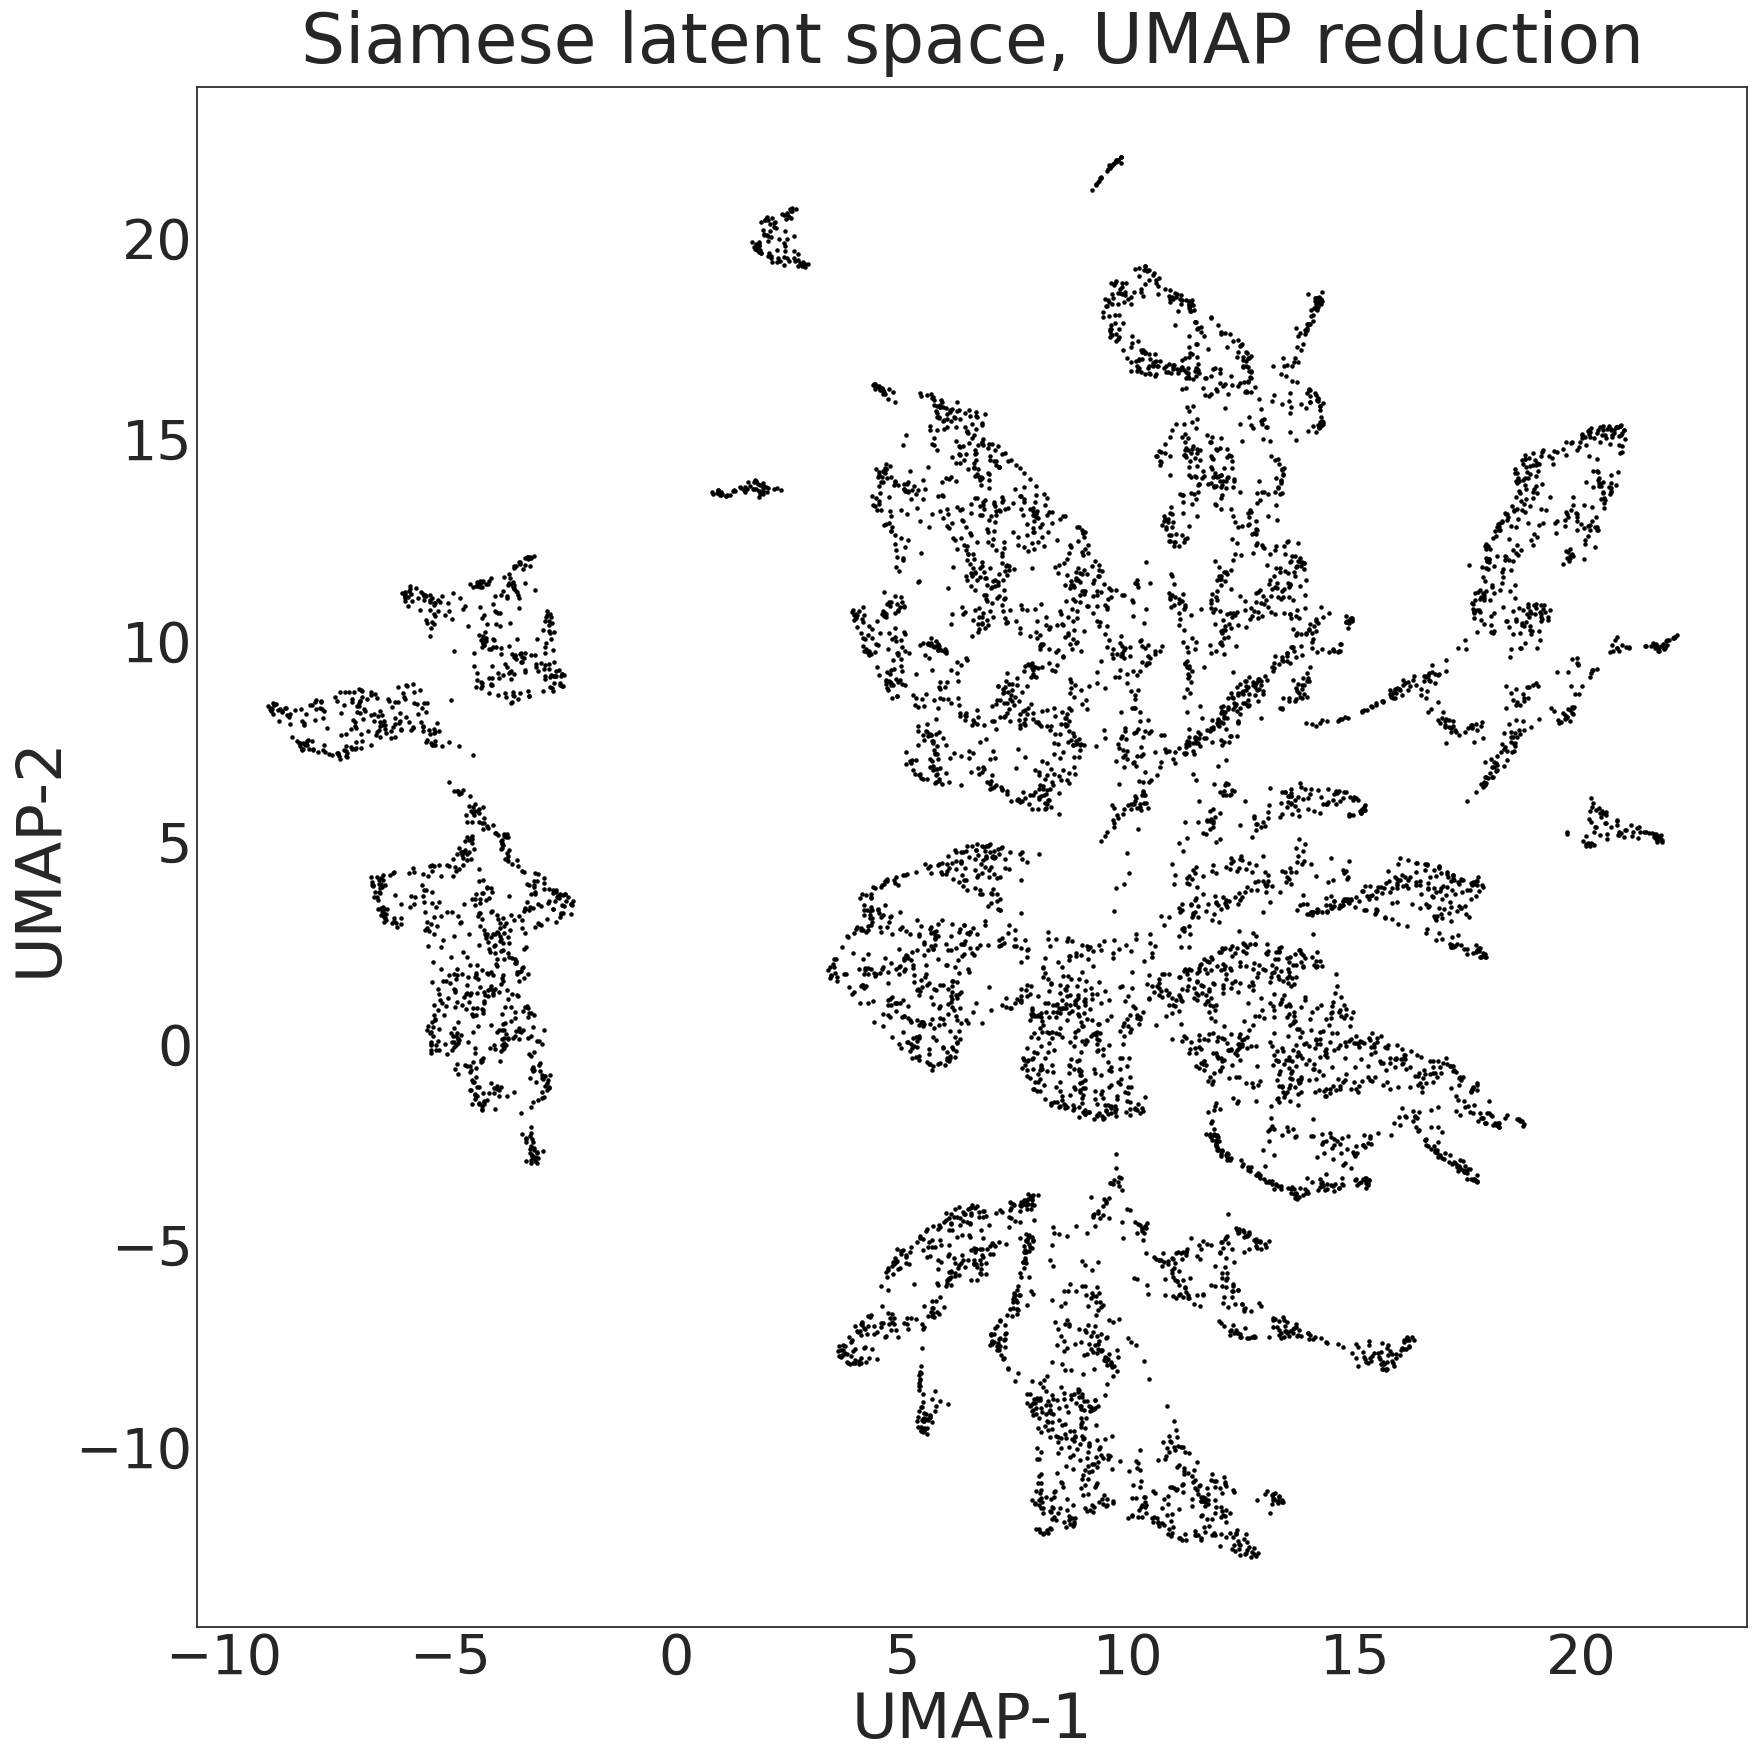

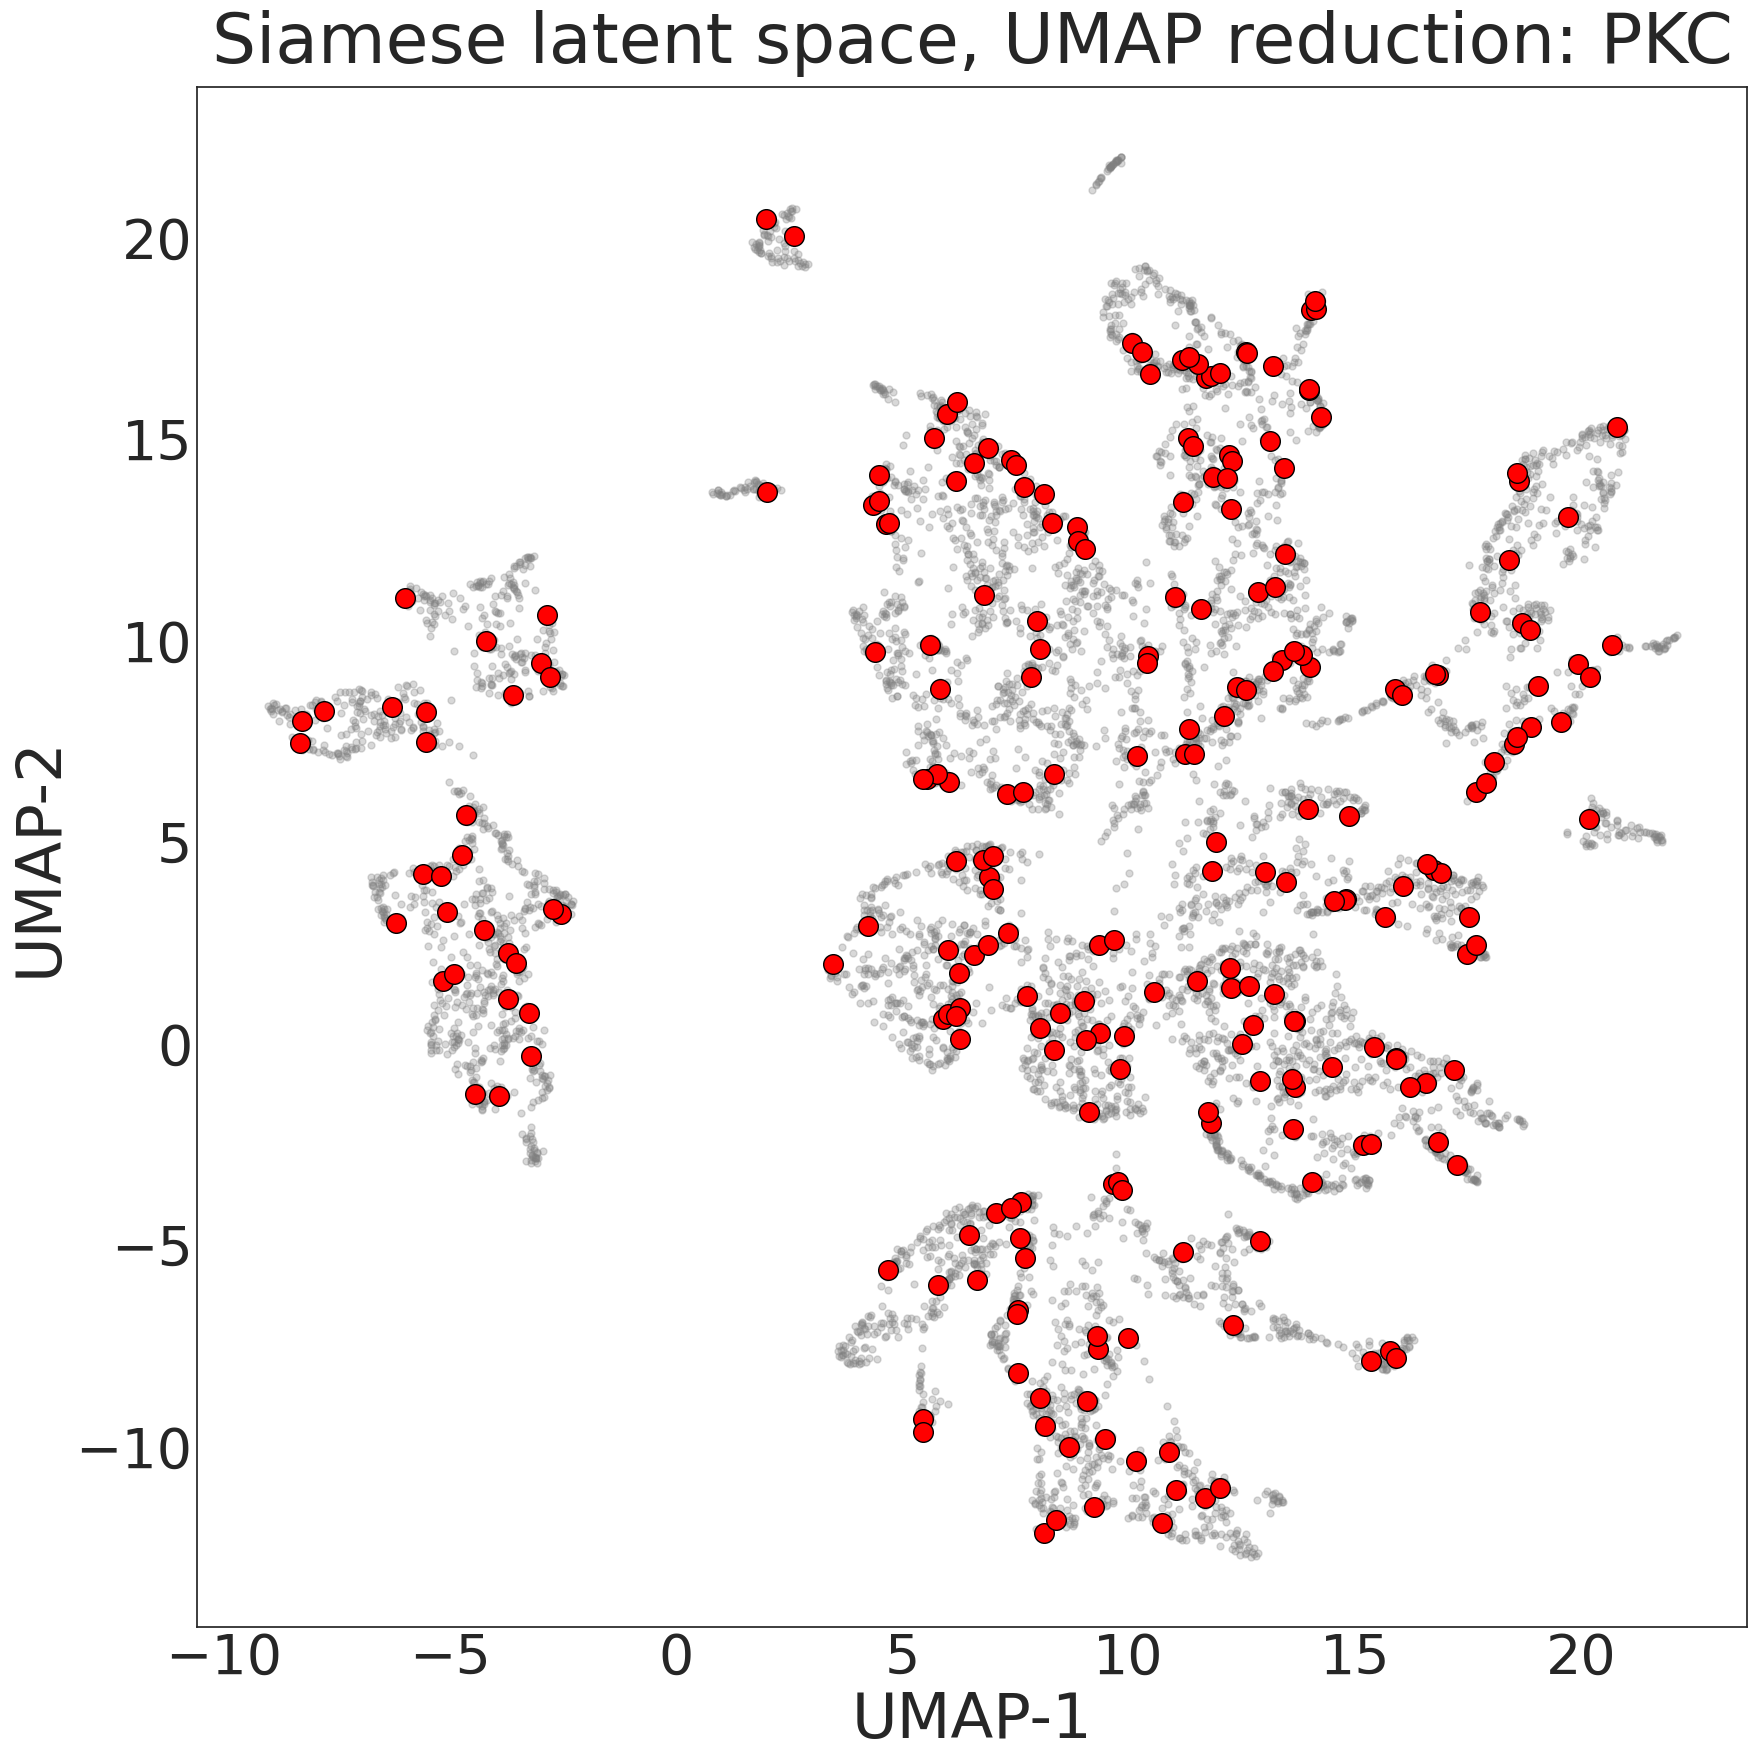

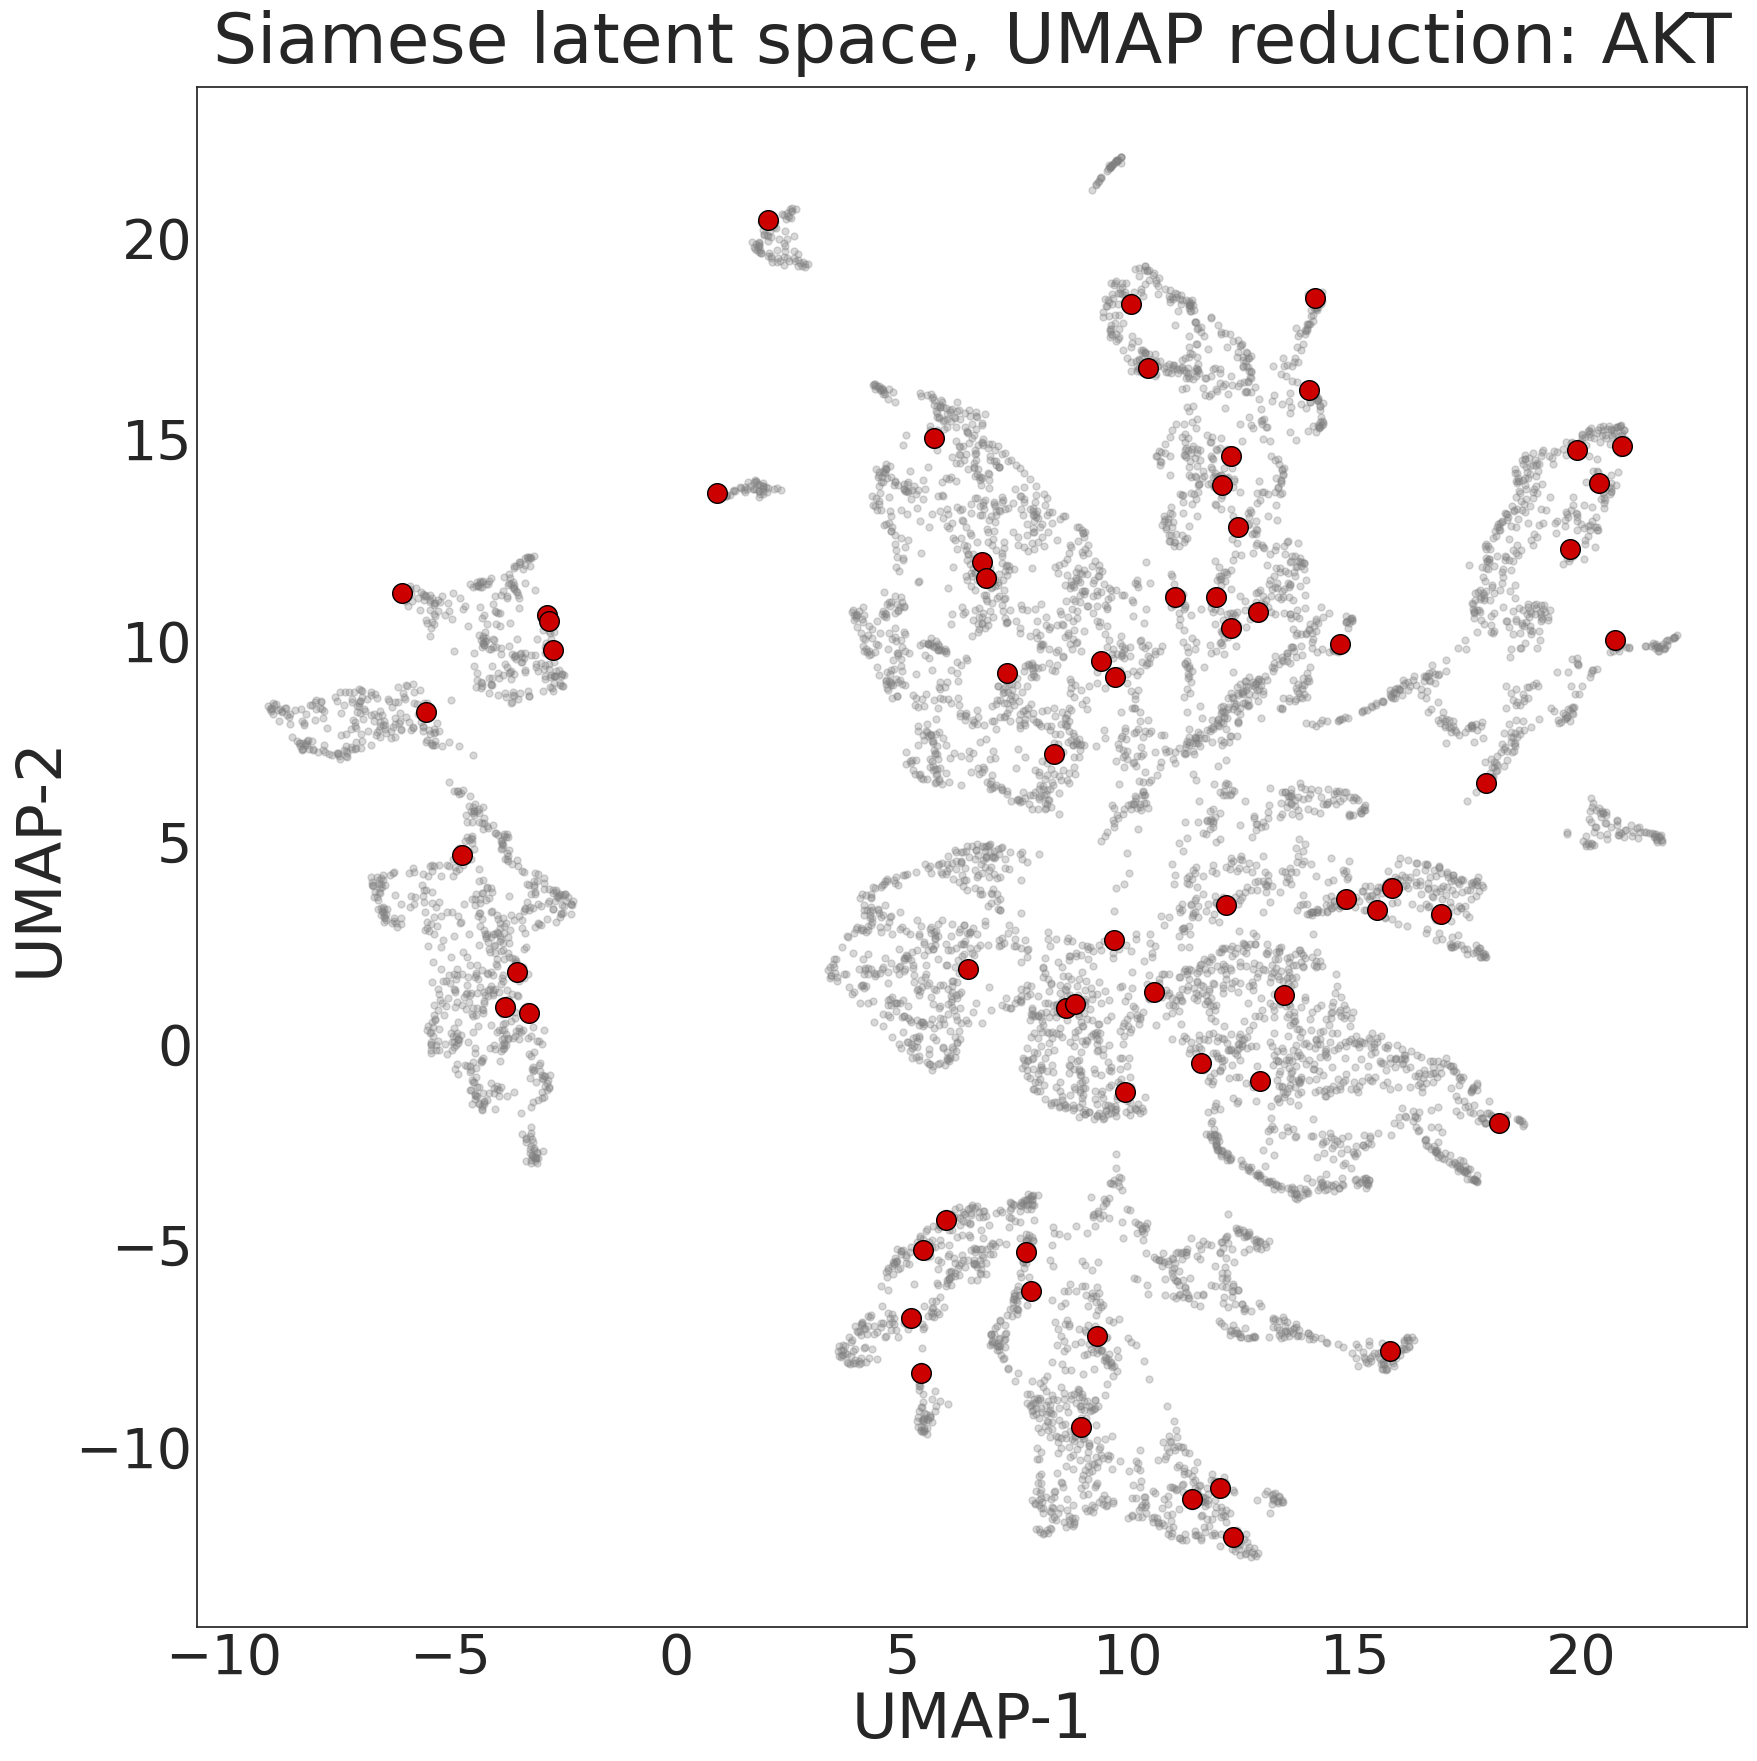

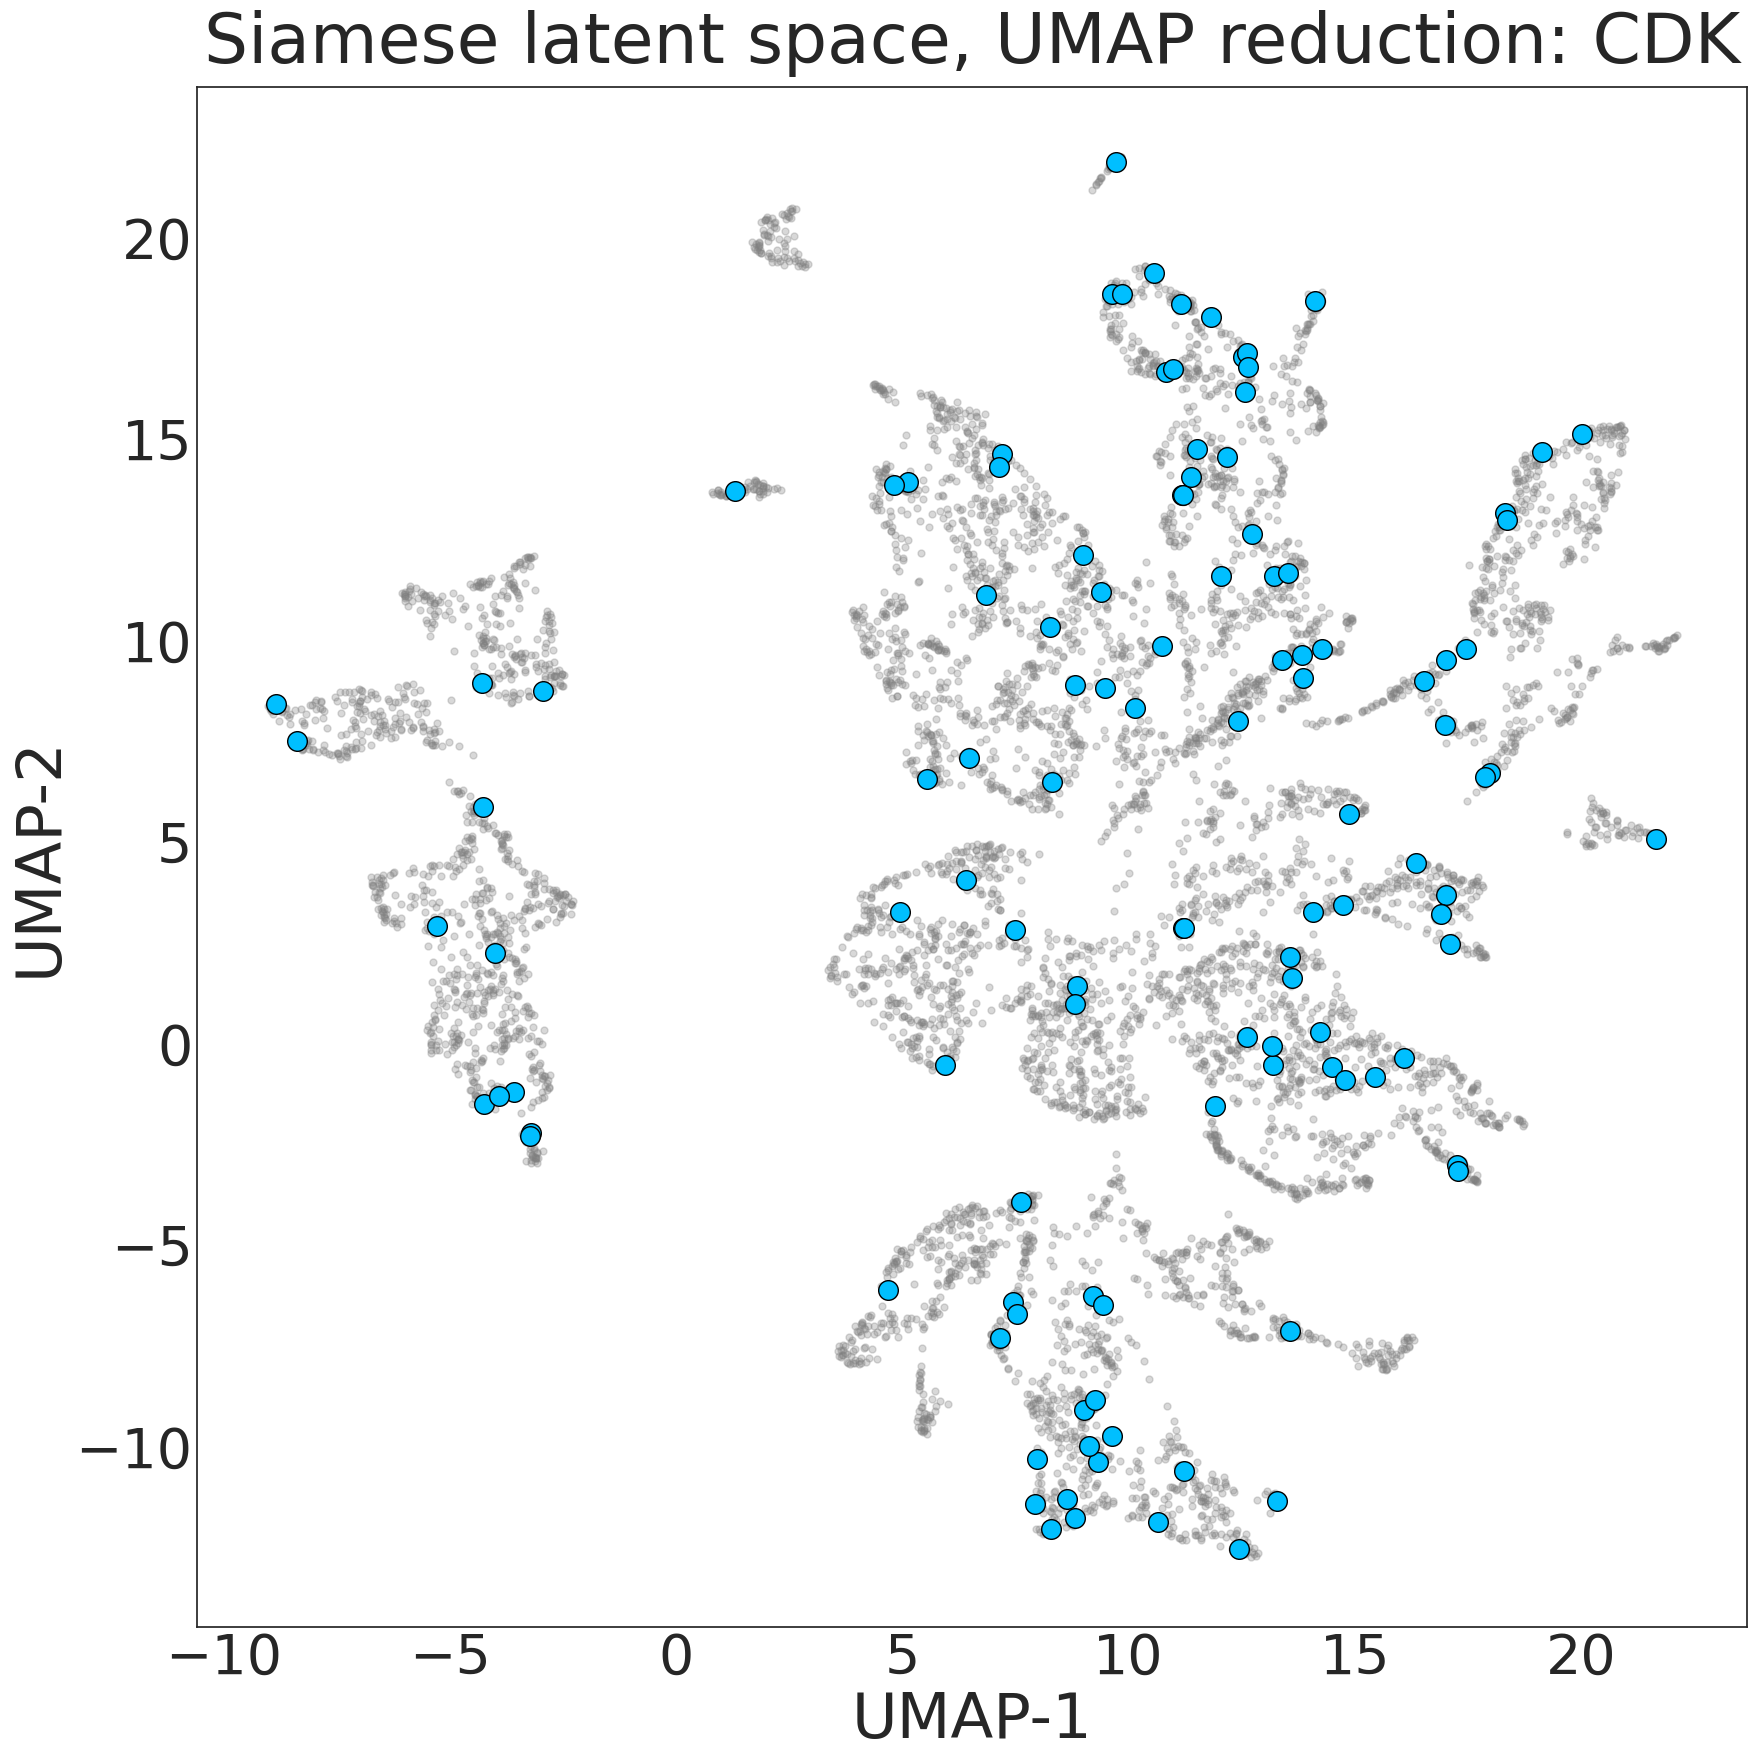

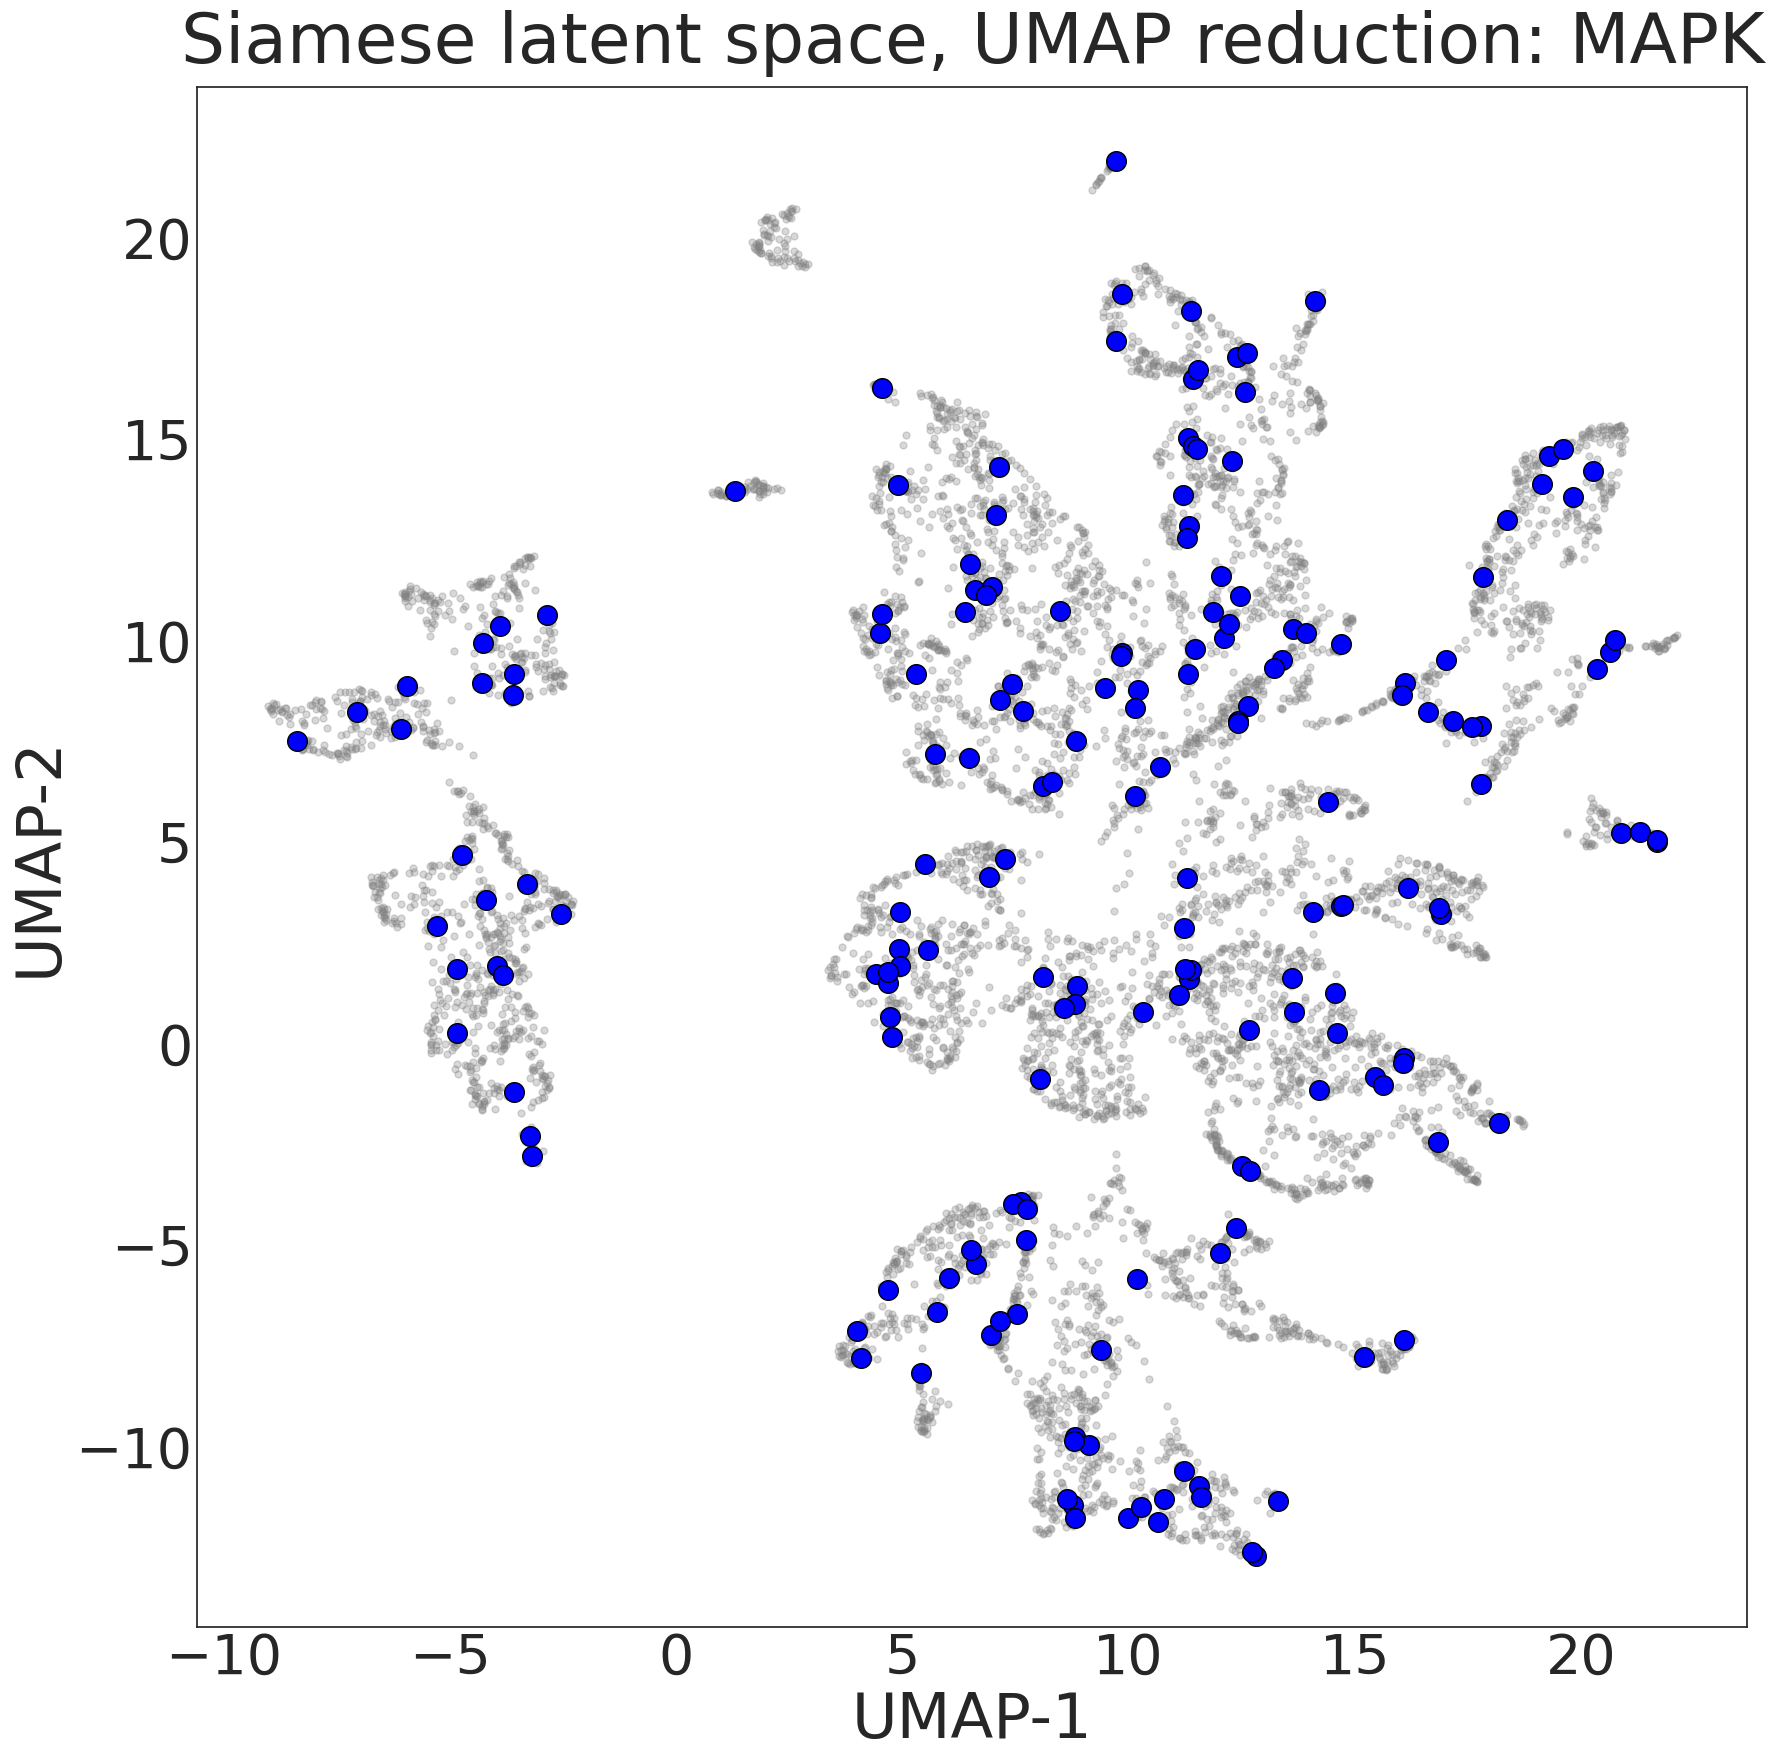

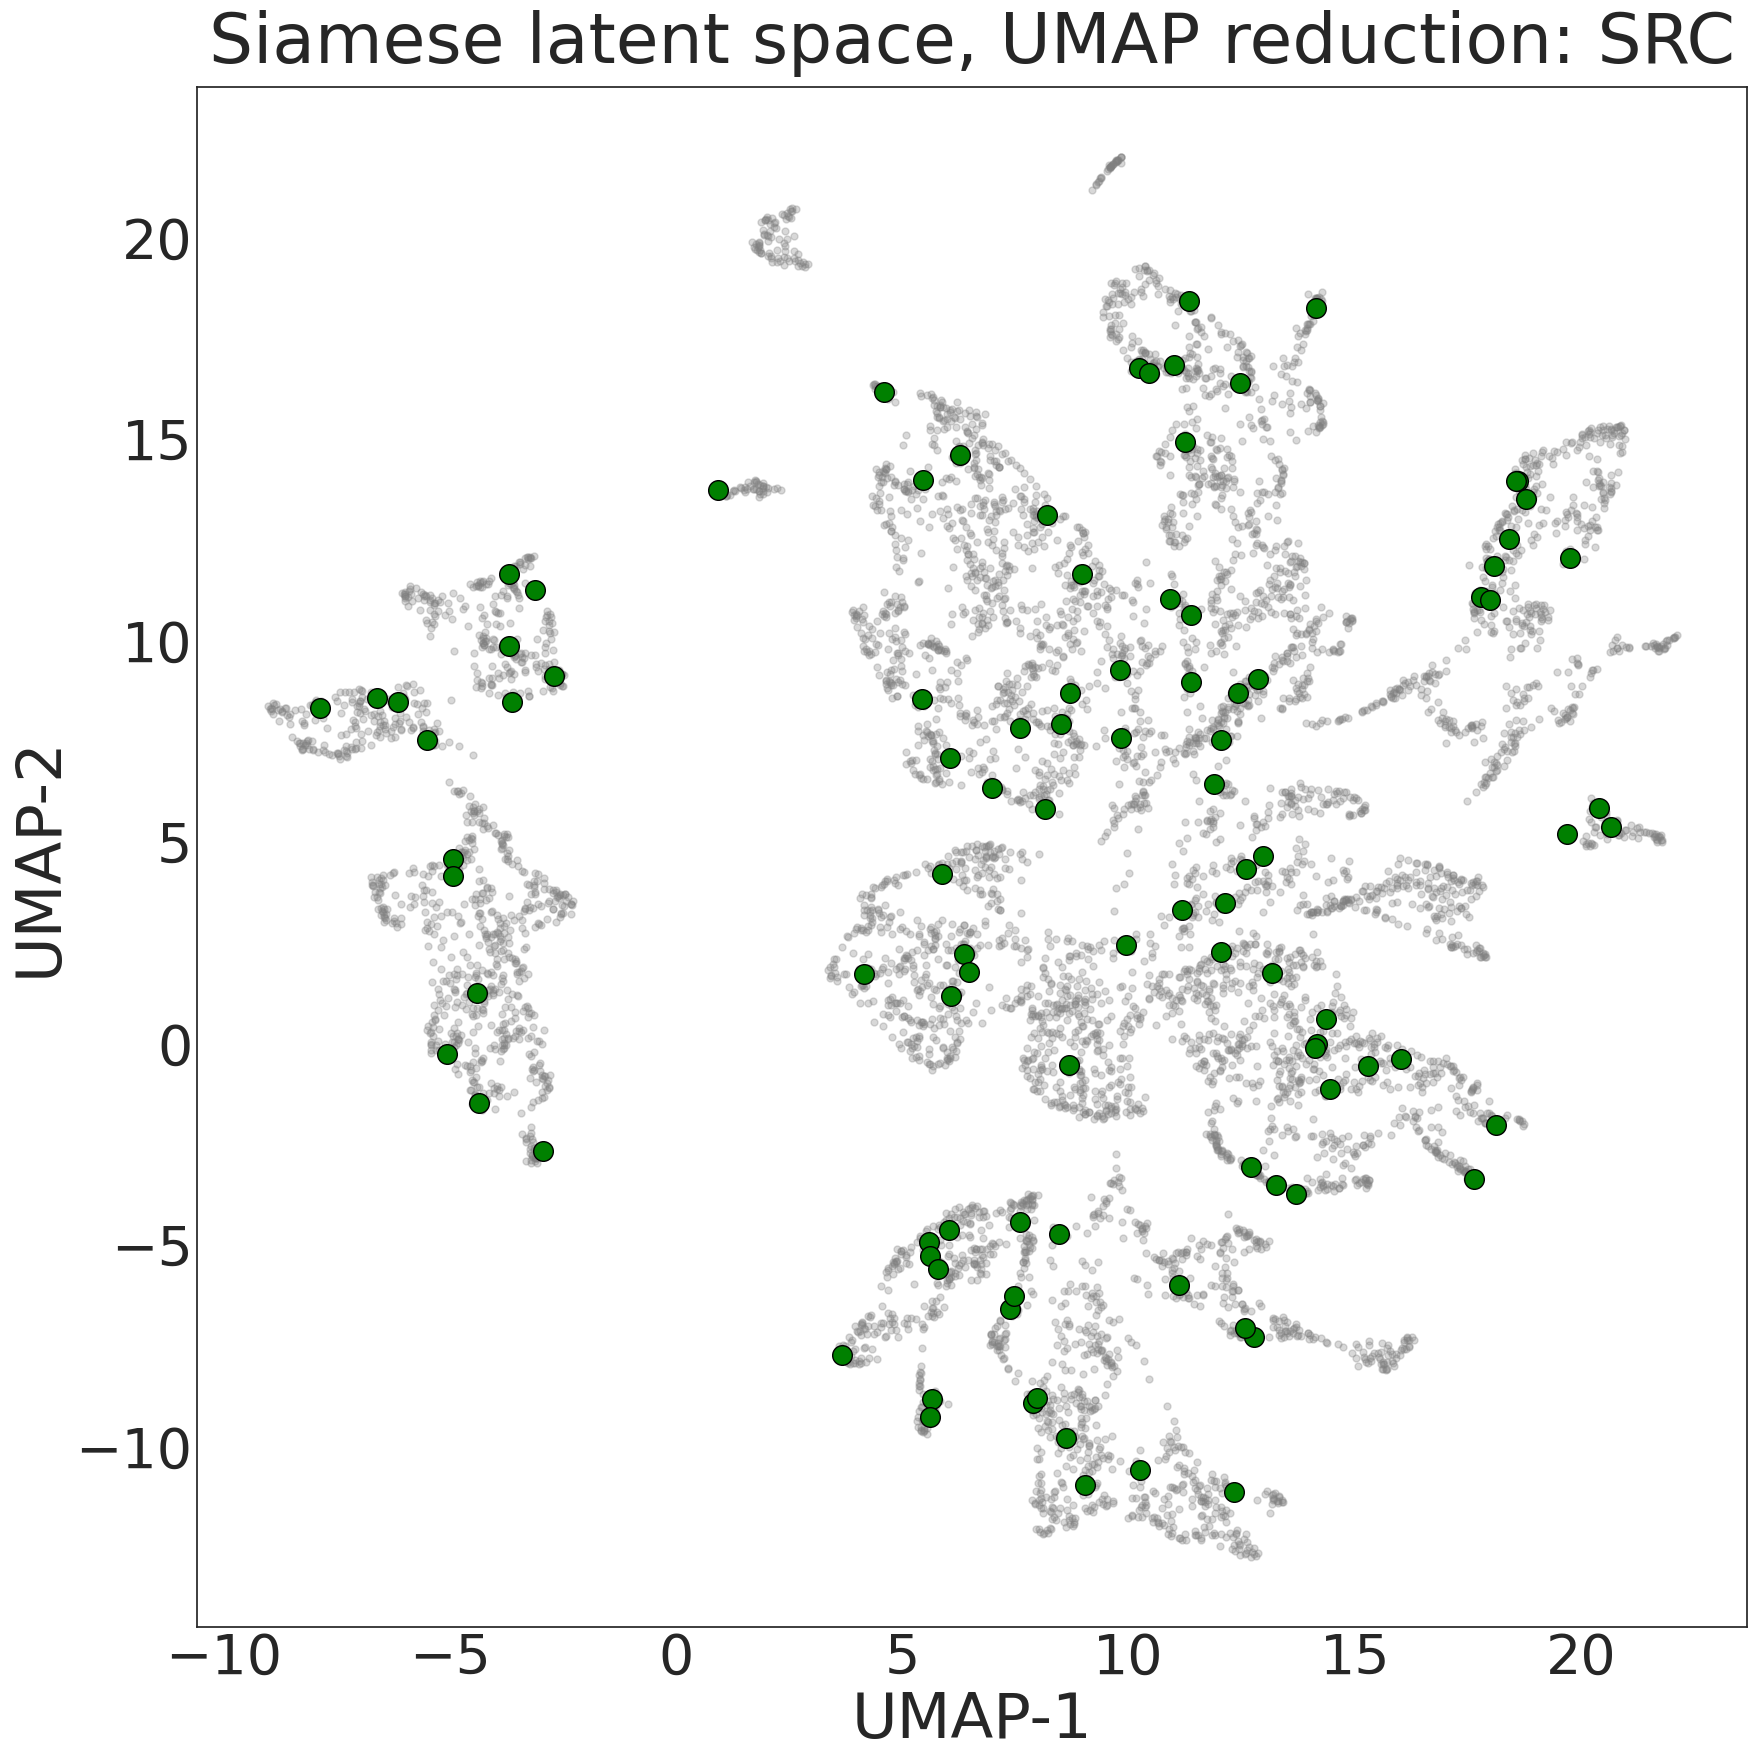

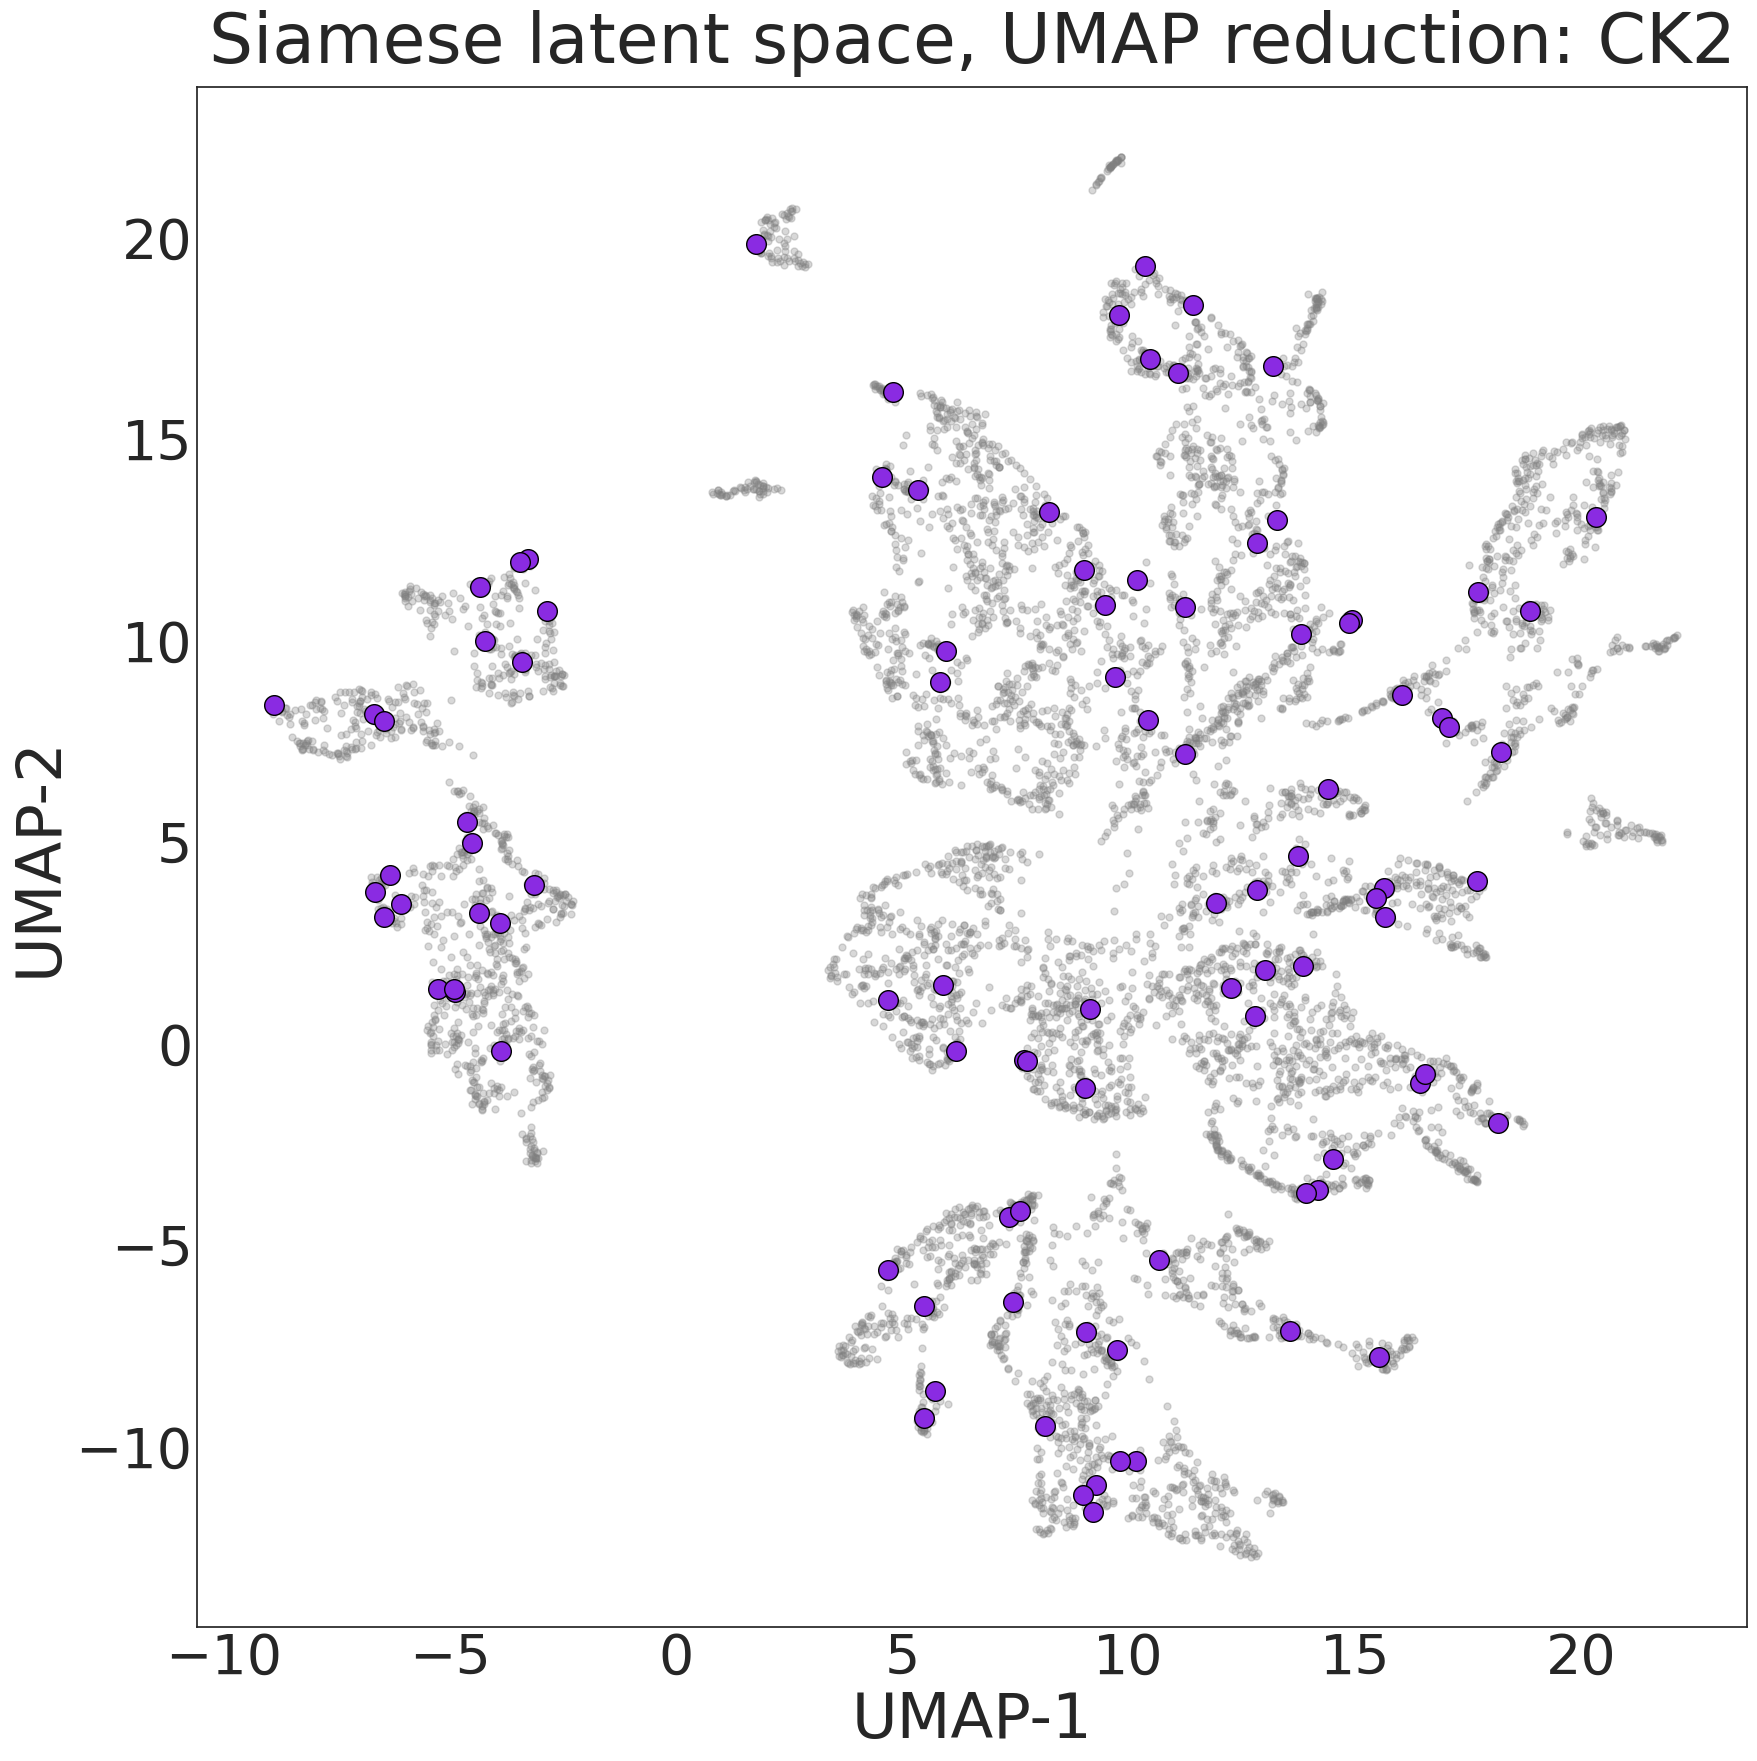

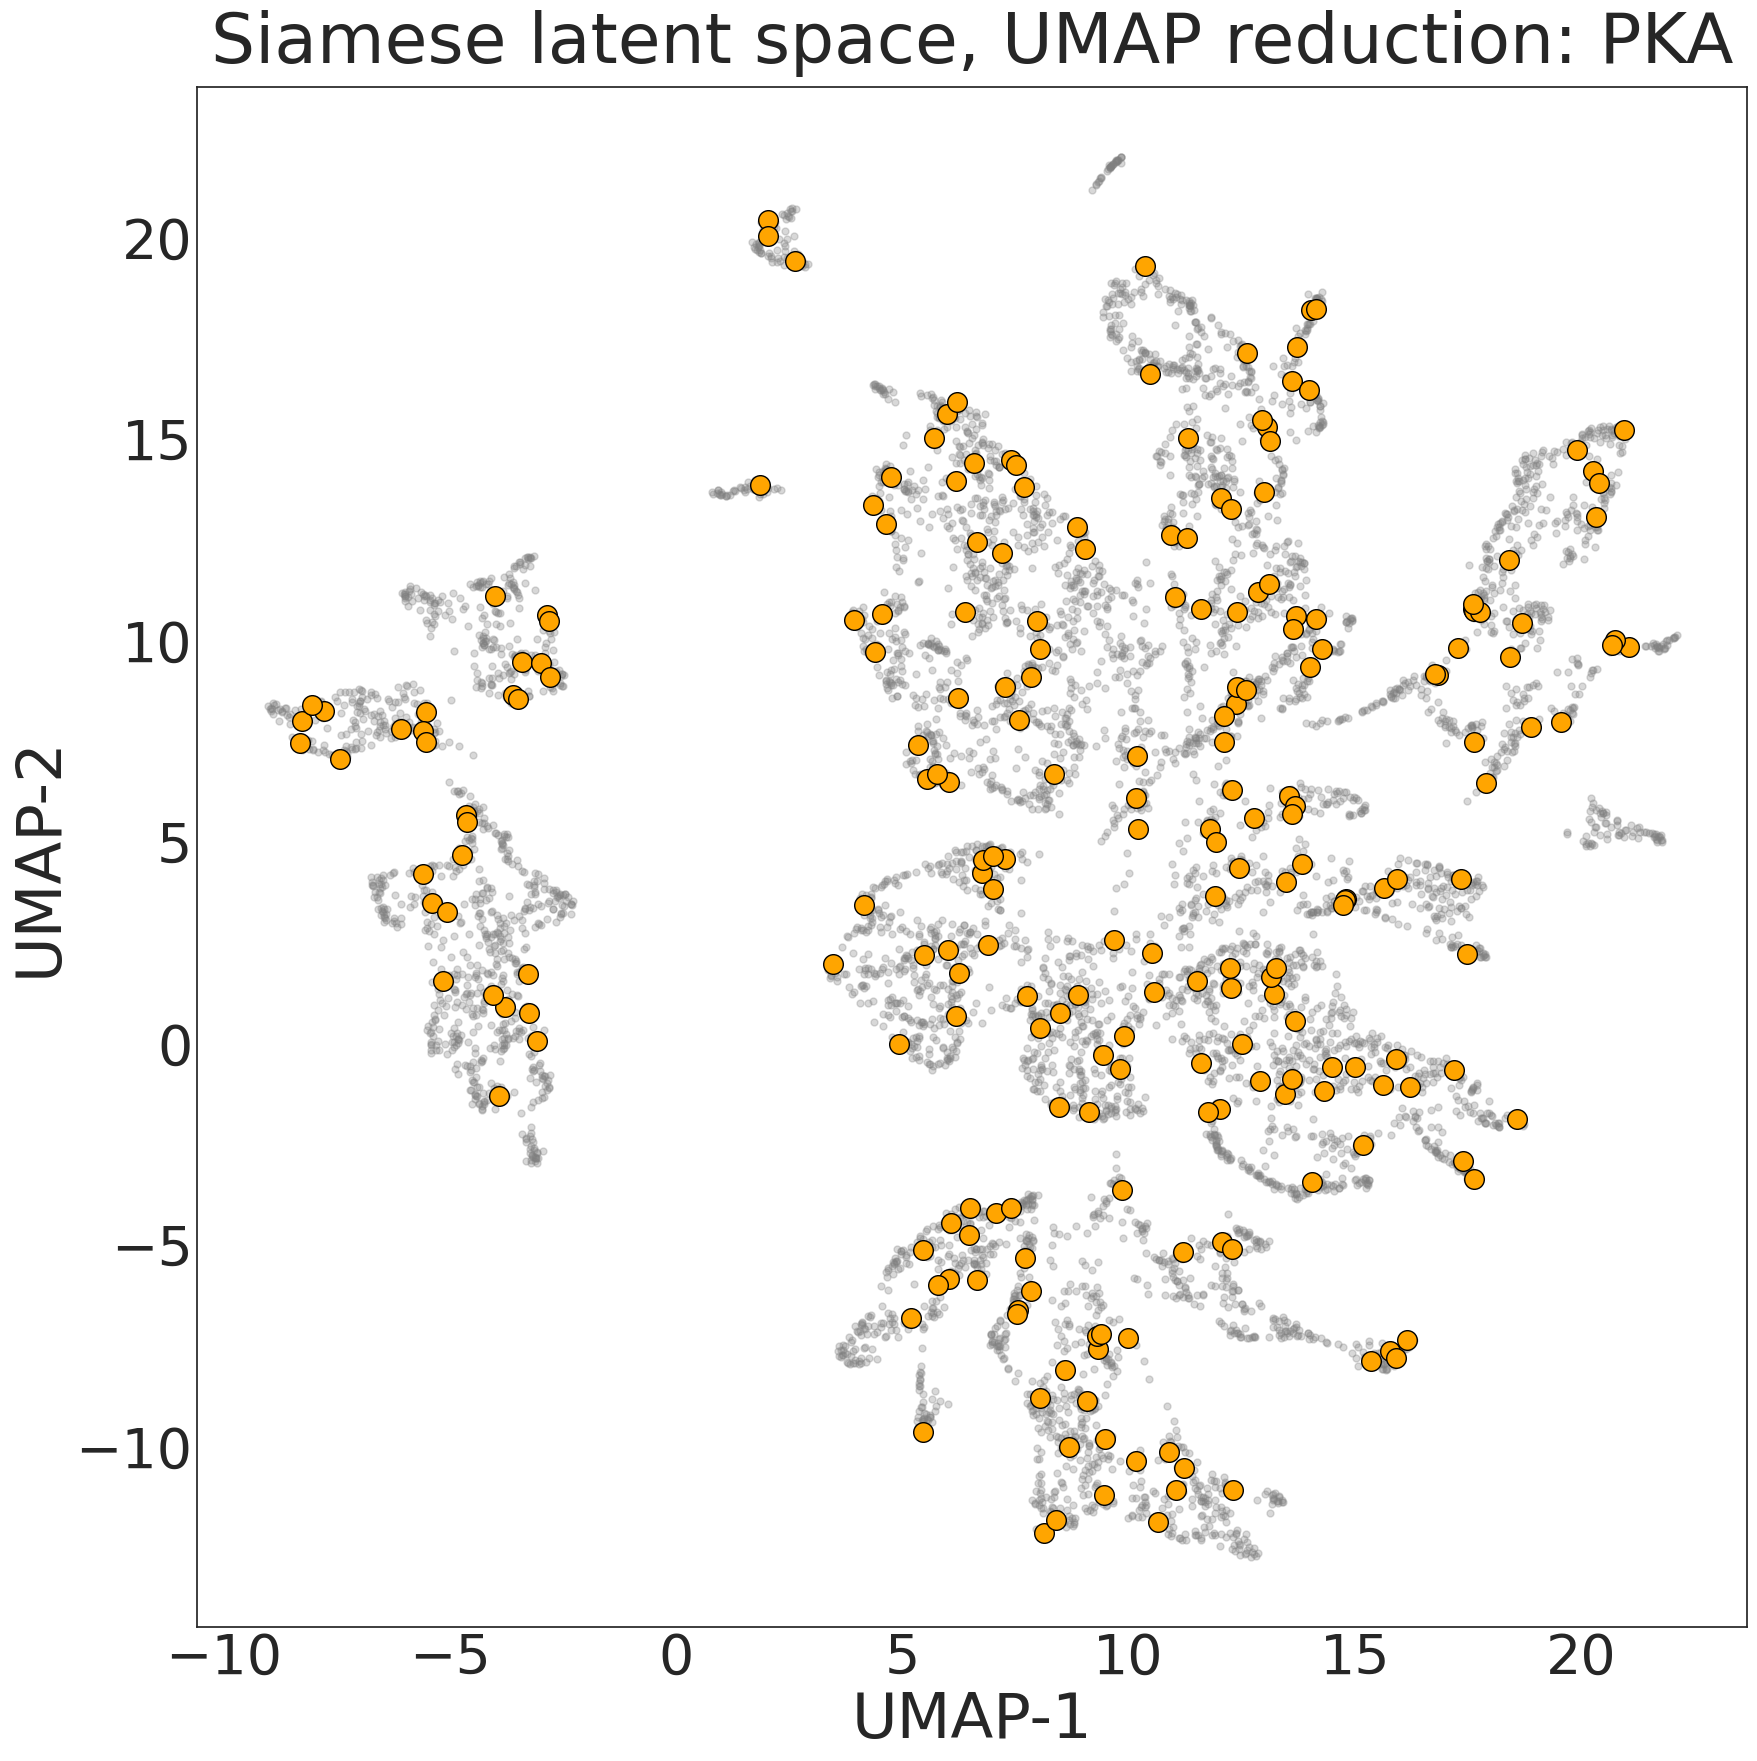

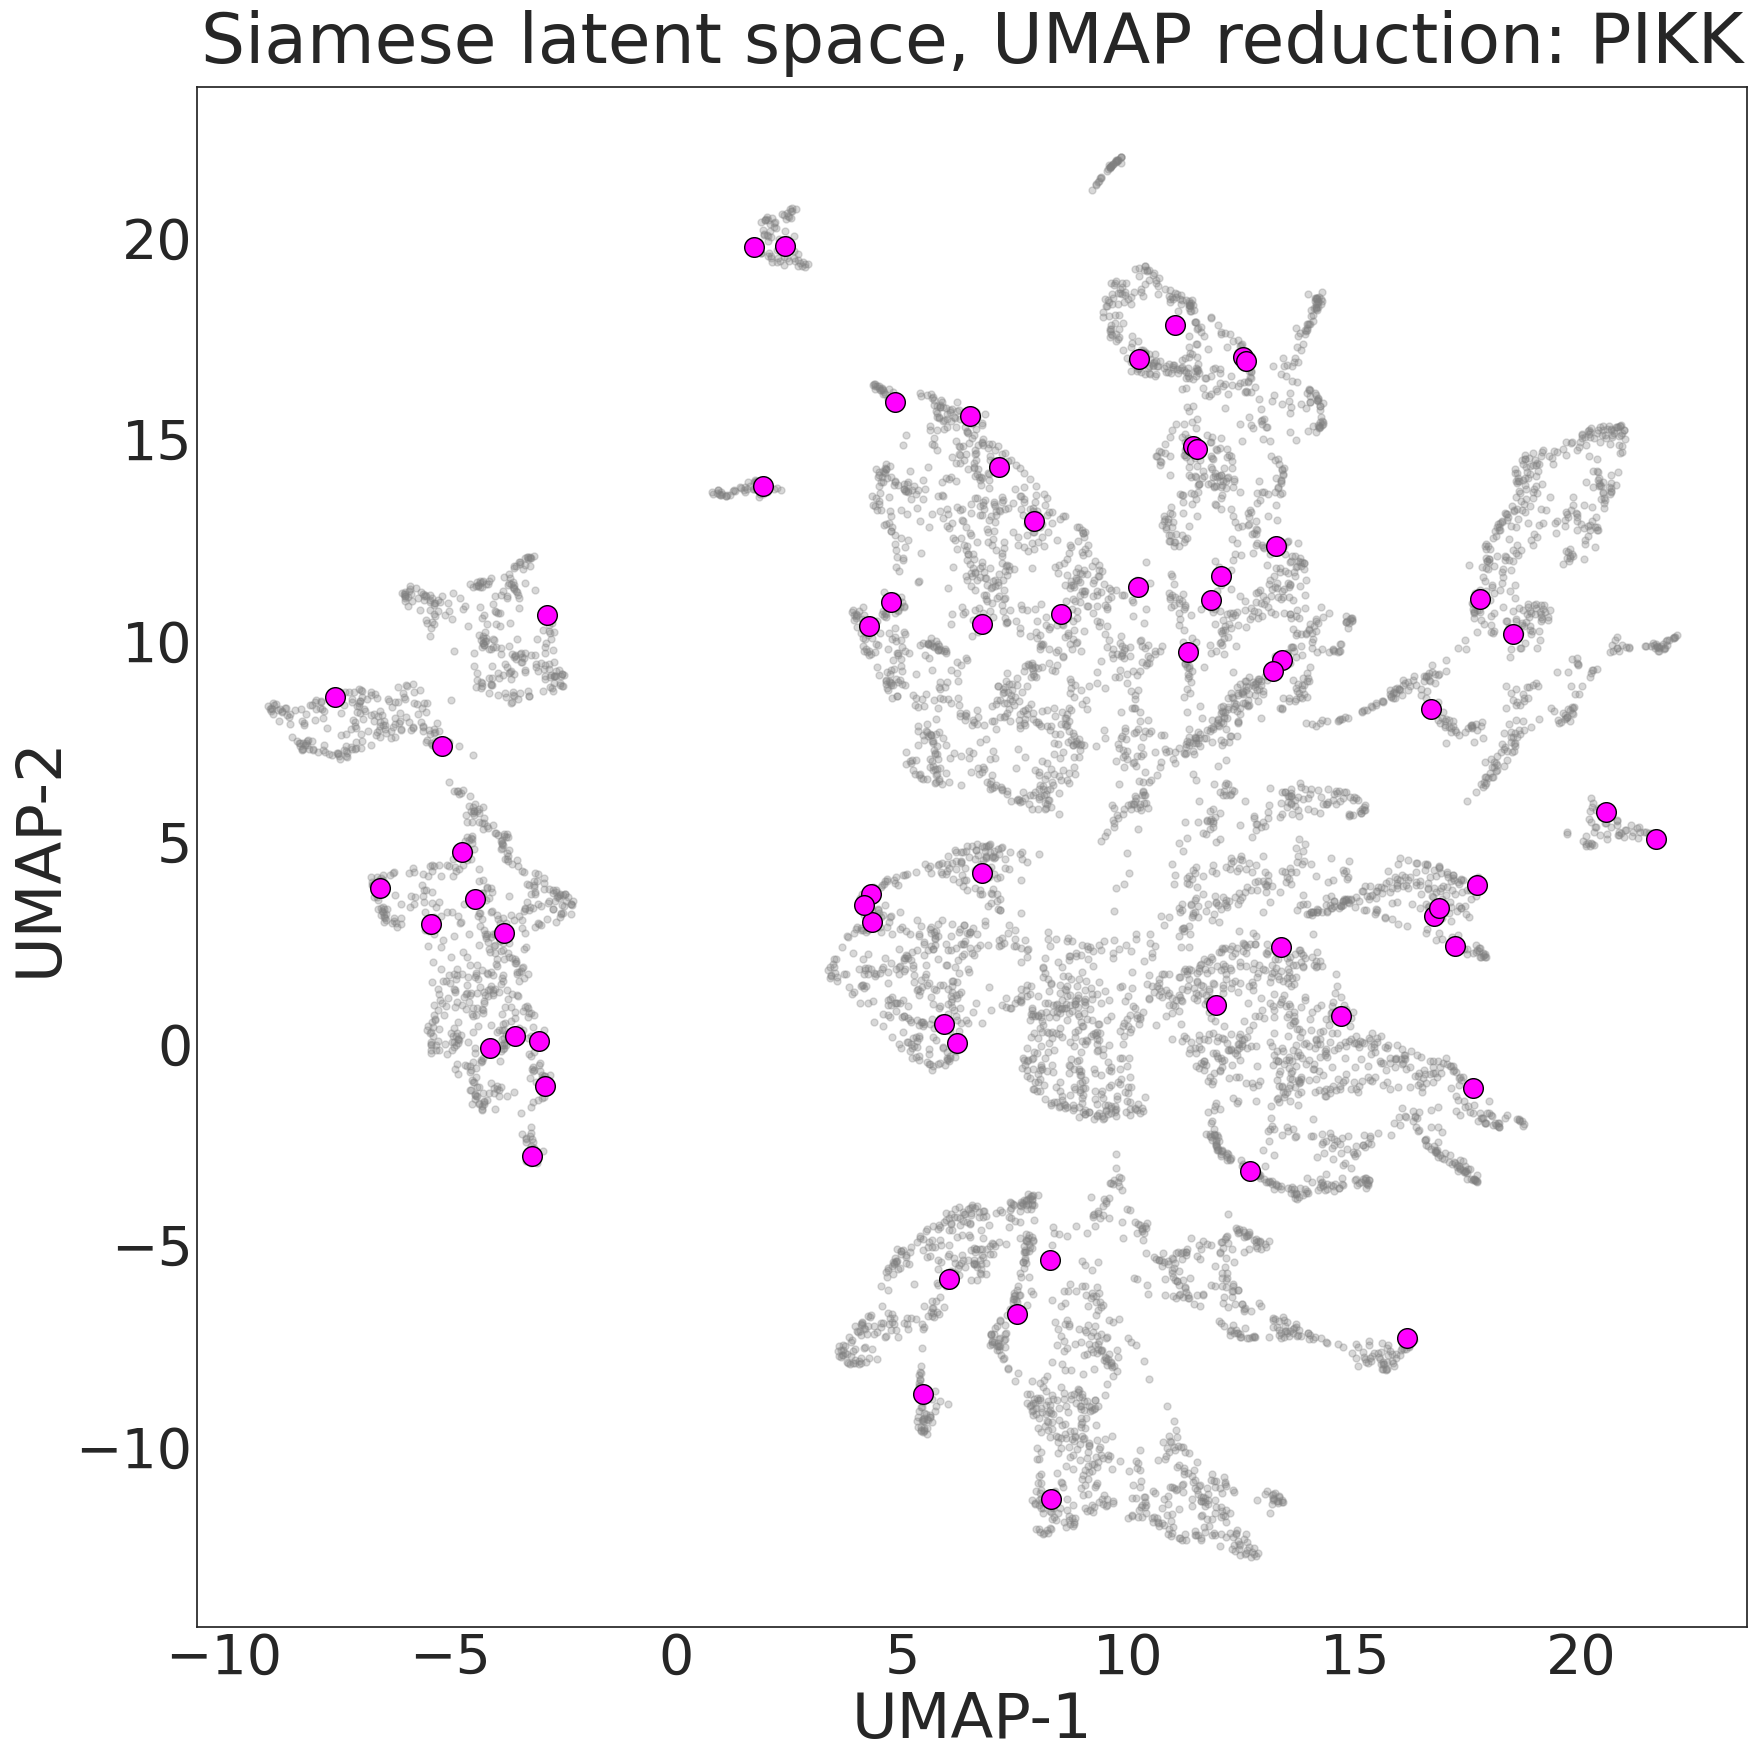

In [14]:
import os

f = 'FIGS_siam/' + run + "/" 
if not os.path.exists(f):
    os.mkdir(f)

label_size = 45
title_size = 50
tick_size = 40

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

colors = ['red','#CD0000','deepskyblue','blue','green','blueviolet','orange','magenta','blueviolet','violet','deeppink','crimson','mediumslateblue','brown']

plt.figure(figsize=(20,20))
plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black', alpha=1) #alpha=0.25)
plt.title("Siamese latent space, UMAP reduction",fontsize=title_size,y=1.01)
plt.xlabel("UMAP-1",fontsize=label_size)
plt.ylabel("UMAP-2",fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig( f + "noHighlights")
plt.show()

pop_fams = ['PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']
# pop_fams = ['CAMK-UNIQUE', 'DYRK', 'CAMKL', 'STE20', 'PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']


i = -1
for _,fam in enumerate(pop_fams):
    
    i+=1
    fIdx = np.where(fams==fam)[0][0]
    plt.figure(figsize=(20, 20))
    plt.title(("Siamese latent space, UMAP reduction: %s" % fam),fontsize=title_size,y=1.01)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.xlabel("UMAP-1",fontsize=label_size)
    plt.ylabel("UMAP-2",fontsize=label_size)
    plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=25,color='grey',alpha=0.30)
    for mIdx, (x, y) in enumerate(zip(pos_umap[:, 0], pos_umap[:, 1])):
        if all_motifs[mIdx] not in test_motifs:
            continue
        elif all_motifxFamMatrix[mIdx][fIdx]==1:
            plt.scatter(x,y,marker='o',s=200,c=colors[i],alpha=1.0,edgecolors='black')          
    plt.savefig((f+"%s" % fam))
    plt.show()